### 必要なソフト
graphvizとpydotを入れておいてください。

### CartPoleでDQN（deep Q-learning）、DDQNを実装・解説【Phythonで強化学習：第2回】
http://neuro-educator.com/rl2/

Q学習では、行動価値関数Q(s_t, a_t)をテーブル（表）で実現しました。  
DQN(Deep Q-learning)では、この関数Qをディープラーニングを用いたディープニューラネットワークで表します。  
本記事でははじめに、DQNについて説明します。  
ここでは、なぜDQNが必要とされたのかを説明し、その後DQNの4つの工夫点を紹介します。  
そしてDDQNについて説明します。  
その後、コードを紹介しながら、実装方法と内容を解説します。  

#### DQNとは

前回実装した、テーブル・表を用いたQ学習には困ったことが2つあります。  
1つ目は、状態s(t)を離散化する必要があることです。  
カートの位置x(t)などは連続値ですが、表で表すためには、適当な範囲内で分割してあげる必要があります。  
こうした連続空間で表現される状態変数の離散化は精度を下げる要因となります。  
2つ目の困った点は、画像などを入力できない点です。  
棒立てのCartPoleくらいであれば状態s(t)を簡単に決めれますが、例えばテトリスなんかだとちょっとしんどい気がします。  
画像を直接入力して強化学習できれば、嬉しいです。  
このような2つの困った点を解決するのに、  
「DL（ディープラーニング）使えばよくない？（とくにCNN)」  
って流れになり、Q関数にディープニューラルネットワークを使用する手法が生まれました。

#### Qネットワーク

最初はQ関数にディープニューラルネットワークを用いるというと、ぱっとイメージが分かないのですが、入力層は状態空間の次元数になります。
CartPoleであれば、カートの位置、速度、棒の角度、角速度の4次元なので、入力層のニューロン数は4つです。  
そして各ニューロンに、カートの位置x(t)などの連続値をそのまま入力します。  
その後、多段のニューラルネットワークを経て出力層に至ります。  
出力層のニューロンの数は行動の選択肢数です。  
CartPoleの場合は右か左にCartを押すので、出力層は2つのニューロンになります。  
そして2つのニューロンがそれぞれのQ(s_t, a_t)の値  
すなわち、状態s(t)で行動a(t)をとった場合にその後得られる報酬の総計  
を出力します。  
 これでQネットワークの入力と出力の関係が分かりました。  
次に学習の説明です。  
このQネットワークに状態s(t)を入力すれば、出力ニューロン1はQ(s_t, 右に押す)、出力ニューロン2はQ(s_t, 左に押す)という値を出力します。  
時刻tで右に押したとすると、実際にもらった報酬r(t)と、その結果状態がs(t+1)になった場合には、max[Q(s_{t+1},a_{t+1})]に時間割引γを掛けたものの和  すなわち、r(t)＋γ・max[Q(s_{t+1},a_{t+1})]  
が、現状でもっとも正しそうなものとなります。  
よって、現状のQネットワークの出力Q(s_t, 右に押す)が、  
r(t)＋γ・max[Q(s_{t+1},a_{t+1})]  
の値に近くなるように、ネットワークの重みを学習してあげます。  
重みを学習するとは、  
Q(s_t, 右に押す)　と　r(t)＋γ・max[Q(s_{t+1},a_{t+1})]  
の誤差を減らす方向に、バックプロパゲーションで各層の各結合の重みを少し変化させるということになります。  
以上で、Q関数にディープラーニングを取り入れることができました。  
ですが、このまま実際に強化学習をやってもうまくいきません。  
DQNにするためには次の4つの工夫が必要です。  

#### DQNの手法

DQNは単純にQ関数をDL（ディープラーニング）にする以外に、4つの工夫があります。  
DLで時系列情報を学習するときに、各stepごとに学習すると、時間方向の相関が強くでてしまい、うまく学習ができないという問題があります。  
そこで、Experience Replayという手法が実装されます。  
逐次順番に学習するのではなく、{s(t), a(t), r(t), s(t+1)}をたくさんメモリに保持しておいて、あとでランダムに学習するという手法をとります。  
※r(t)は時刻tでもらえる報酬です。  


工夫の2つ目はFixed Target Q-Networkです。  
これは、Qネットワークを学習する際に、max[Q(s_{t+1},a_{t+1})]を同じQネットワークから求めるのではなく、少し前の固定しておいたQネットワークを使用するという方法です。  
工夫1, 2はメモリからランダムに取り出した学習データをバッチ学習すれば、自然と実現されます。  


工夫3は報酬のclippingです。  
各ステップで得られる報酬を-1, 0, 1のいずれかに固定しておく方法です。  
こうすることで、ゲーム内容（学習対象）によらず、同じハイパーパラメータのDLを使用できるというメリットがあります。  


最後の工夫4が誤差関数の工夫です。  
DLでは現状のQネットワークの出力Q(s_t, 右に押す)が、  
r(t)＋γ・max[Q(s_{t+1},a_{t+1})]  
の値に近くなるように、ネットワークの重みを学習してあげます。  
このときに二乗誤差{r(t)＋γ・max[Q(s_{t+1},a_{t+1})] – Q(s_t, 右に押す)}^2  
を使用してバックプロパゲーションを計算するのが一般的です。  
ですが、この二乗誤差が1以上になる場合には、  
abs{r(t)＋γ・max[Q(s_{t+1},a_{t+1})] – Q(s_t, 右に押す)}  
を使用することにします。  
こうすることで学習が安定しやすいというメリットがあります。  


参考:DQNをKerasとTensorFlowとOpenAI Gymで実装する
https://elix-tech.github.io/ja/2016/06/29/dqn-ja.html
 

なお、このような誤差関数（損失関数）はHuber関数と呼ばれます。  
DQNでは、以上の4点を工夫として、実装してあげます。

#### DDQN

最後にDDQN（Double DQN）を説明します。  
Q学習のときに行動選択にQ関数をFixed Target Q-Networkで1バッチ分前の関数を使用していましたが、もっと前の別のQ関数を使用する手法をDDQNと言います。  
今回は、1試行前のQネットワークを使用することでDDQNを実現します。  
DDQNの詳細はこちらが参考になります  
●introduction to double deep Q-learning（日本語）https://www.slideshare.net/ssuser07aa33/introduction-to-double-deep-qlearning

#### DQN、DDQNの実装とコード解説

紹介しました4つの工夫を念頭に、コードを説明していきます。  
DQN、DDQNは同じひとつのファイルで、途中の設定パラメータで切り替えています。  
実装にはこれらを参考にしました。  
* OpenAI Gymの CartPole問題をDQNで解いた http://futurismo.biz/archives/6610/
* udacity/deep-learning https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb
* AI-blog/CartPole-DQN.py https://github.com/jaara/AI-blog/blob/master/CartPole-DQN.py

## 必要なライブラリのインポート
最初は必要なライブラリのインポートです。  
今回はディープラーニングのライブラリとして、Kerasを使用しています。

In [ ]:
# coding:utf-8
import gym  # 倒立振子(cartpole)の実行環境
import numpy as np
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import plot_model
from collections import deque
from gym import wrappers  # gymの画像保存
from keras import backend as K
import tensorflow as tf

## 損失関数の定義
損失関数にhuber関数を使用します 参考https://github.com/jaara/AI-blog/blob/master/CartPole-DQN.py  
工夫点4のHuber損失関数を定義しています。  
Kerasには、Huber関数は入っていないので、自分で定義します。  
誤差が±1以上の場合で場合分けして、二乗誤差と絶対誤差の小さい方を使用します。  
Kerasではバッチ内の施行ごとに異なる損失関数を設定できないので、tensorflowのwhere関数を使用します  



Huber loss:  
Huber損失とは、統計学において、ロバスト回帰で使われる損失関数の一つ。二乗誤差損失よりも外れ値に敏感ではない。


損失関数：ようは2つの値の差が小さくなるような関数のことのようです。

In [ ]:
def huberloss(y_true, y_pred):
    err = y_true - y_pred
    cond = K.abs(err) < 1.0
    L2 = 0.5 * K.square(err)
    L1 = (K.abs(err) - 0.5)
    loss = tf.where(cond, L2, L1)  # Keras does not cover where function in tensorflow :-(
    return K.mean(loss)

## Q関数をディープラーニングのネットワークをクラスとして定義

Q関数として使用するディープニューラルネットワークのクラスを定義します。  
今回は入力層+中間層2層＋出力層です。  
画像で示すとこんな感じです。  
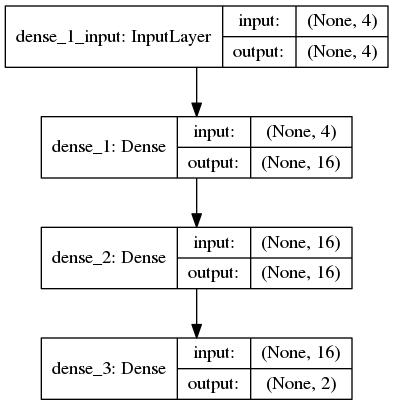


そして、Qネットワークの各重みを学習する関数を定義します。


※dense は「密な」という意味だが、前の層のすべてのノードから、この層のすべてのノードに対して、すべての矢印を引っ張るので、そういう意味で密なんだと思う。

if notの部分は、次の状態s(t+1)が、終了でない（こけたり、200step経過）していないときは教師信号となる報酬はr(t)＋γ・max[Q(s_{t+1},a_{t+1})]とし、次の状態がなく、時刻tで終了したときは教師信号となる報酬はr(t)として、学習しています。

In [ ]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, action_size=2, hidden_size=10):
        self.model = Sequential()
        self.model.add(Dense(hidden_size, activation='relu', input_dim=state_size))
        self.model.add(Dense(hidden_size, activation='relu'))
        self.model.add(Dense(action_size, activation='linear'))
        self.optimizer = Adam(lr=learning_rate)  # 誤差を減らす学習方法はAdam
        # self.model.compile(loss='mse', optimizer=self.optimizer)
        self.model.compile(loss=huberloss, optimizer=self.optimizer)
 
    # 重みの学習
    def replay(self, memory, batch_size, gamma, targetQN):
        inputs = np.zeros((batch_size, 4))
        targets = np.zeros((batch_size, 2))
        mini_batch = memory.sample(batch_size)
 
        for i, (state_b, action_b, reward_b, next_state_b) in enumerate(mini_batch):
            inputs[i:i + 1] = state_b
            target = reward_b
 
            if not (next_state_b == np.zeros(state_b.shape)).all(axis=1):
                # 価値計算（DDQNにも対応できるように、行動決定のQネットワークと価値観数のQネットワークは分離）
                retmainQs = self.model.predict(next_state_b)[0]
                next_action = np.argmax(retmainQs)  # 最大の報酬を返す行動を選択する
                target = reward_b + gamma * targetQN.model.predict(next_state_b)[0][next_action]
                
            targets[i] = self.model.predict(state_b)    # Qネットワークの出力
            targets[i][action_b] = target               # 教師信号
            self.model.fit(inputs, targets, epochs=1, verbose=0)  # epochsは訓練データの反復回数、verbose=0は表示なしの設定

## Experience ReplayとFixed Target Q-Networkを実現するメモリクラス

ここでは学習する内容を保存しておく記憶クラスを定義しています。  
addが追加、sampleはランダムに引数分だけ保存内容を取り出します。  
lenは現在保存されている量を返します。  

In [ ]:
class Memory:
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
 
    def add(self, experience):
        self.buffer.append(experience)
 
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]
 
    def len(self):
        return len(self.buffer)

## カートの状態に応じて、行動を決定するクラス

最後のクラスは状態s(t)に応じて、Cartを右に押すか左に押すかを決めるActorのクラスを定義しています。  
ここではε-greedy法を採用し、最初は探索をするが、徐々に最適行動のみを行うようにしています。

In [ ]:
class Actor:
    def get_action(self, state, episode, targetQN):   # [C]ｔ＋１での行動を返す
        # 徐々に最適行動のみをとる、ε-greedy法
        epsilon = 0.001 + 0.9 / (1.0+episode)
 
        if epsilon <= np.random.uniform(0, 1):
            retTargetQs = targetQN.model.predict(state)[0]
            action = np.argmax(retTargetQs)  # 最大の報酬を返す行動を選択する
 
        else:
            action = np.random.choice([0, 1])  # ランダムに行動する
 
        return action

## メイン関数開始

### 初期設定
ここからメイン関数がはじまります。  
最初は定数を定義します。  
DQN_MODEを1にするとDQN、0にするとDDQNとなります。

In [ ]:
DQN_MODE = 1    # 1がDQN、0がDDQNです
LENDER_MODE = 1 # 0は学習後も描画なし、1は学習終了後に描画する
 
env = gym.make('CartPole-v0')
num_episodes = 299  # 総試行回数
max_number_of_steps = 200  # 1試行のstep数
goal_average_reward = 195  # この報酬を超えると学習終了
num_consecutive_iterations = 10  # 学習完了評価の平均計算を行う試行回数
total_reward_vec = np.zeros(num_consecutive_iterations)  # 各試行の報酬を格納
gamma = 0.99    # 割引係数
islearned = 0  # 学習が終わったフラグ
isrender = 0  # 描画フラグ
# ---
hidden_size = 16               # Q-networkの隠れ層のニューロンの数
learning_rate = 0.00001         # Q-networkの学習係数
memory_size = 10000            # バッファーメモリの大きさ
batch_size = 32                # Q-networkを更新するバッチの大記載

### Qネットワークとメモリ、Actorの生成

作成した3つのクラスからインスタンスを生成します。  
Qネットワークについては、メインで使用し、価値関数を計算したり、行動を決定するためのmainQNと、max[Q(s_{t+1},a_{t+1})] を計算するtargetQNを分離しています。  
またネットワークの状態を画像で出力するには、plot_modelを使用します。  
ただし、他のライブラリをインストールしておく必要があります。

In [ ]:
mainQN = QNetwork(hidden_size=hidden_size, learning_rate=learning_rate)     # メインのQネットワーク
targetQN = QNetwork(hidden_size=hidden_size, learning_rate=learning_rate)   # 価値を計算するQネットワーク
# plot_model(mainQN.model, to_file='Qnetwork.png', show_shapes=True)        # Qネットワークの可視化
memory = Memory(max_size=memory_size)
actor = Actor()

### メインルーチン

実際のメインルーチンが始まります。  
for文のネストになっており、試行数のfor文のなかに、時間stepのfor文があります。

行っていることは、
1. actorから最適な行動を求める
2. 実際にその行動を行って、s(t+1)とr(t)を求める
    ※s(t+1)はKerasで扱えるようにlist型のstateを、1行4列の行列に変換
3. if doneは、終了状態になった場合は、s(t+1)にゼロ行列を入れておき、
4. 報酬r(t)を決める
    今回は立っているときは報酬0、195ステップ以上立って終了したら報酬1、それ以前に倒れたら報酬-1を与えています。
5. s(t), a(t), r(t), s(t+1)をメモリに追加します。
6. Q学習を行います。
    メモリ内容がバッチサイズより大きくなったステップから学習を開始します。  
    DQNの場合は学習後に価値観数を返すmainQNと、行動を決めるtargetQNを同じにします。  
    DDQNの場合は、各試行の最初だけ価値観数を返すmainQNと、行動を決めるtargetQNを同じにしています。  
7. 最後は、各ステップの状況の出力と、各試行終わりの平均報酬から学習終了を判断しています。

以上で、DQN、DDQNが実装されました。  
どちらも100試行程度で、学習が収束します。  
DDQNの方が早い気がします。  

In [ ]:
for episode in range(num_episodes):  # 試行数分繰り返す
    env.reset()  # cartPoleの環境初期化
    state, reward, done, _ = env.step(env.action_space.sample())  # 1step目は適当な行動をとる
    state = np.reshape(state, [1, 4])   # list型のstateを、1行4列の行列に変換
    episode_reward = 0
 
    targetQN = mainQN   # 行動決定と価値計算のQネットワークをおなじにする
 
    for t in range(max_number_of_steps + 1):  # 1試行のループ
        if (islearned == 1) and LENDER_MODE:  # 学習終了したらcartPoleを描画する
#             env.render()
            time.sleep(0.1)
            print(state[0, 0])  # カートのx位置を出力するならコメントはずす
 
        action = actor.get_action(state, episode, mainQN)   # 時刻tでの行動を決定する
        next_state, reward, done, info = env.step(action)   # 行動a_tの実行による、s_{t+1}, _R{t}を計算する
        next_state = np.reshape(next_state, [1, 4])     # list型のstateを、1行4列の行列に変換
 
        # 報酬を設定し、与える
        if done:
            next_state = np.zeros(state.shape)  # 次の状態s_{t+1}はない
            if t < 195:
                reward = -1  # 報酬クリッピング、報酬は1, 0, -1に固定
            else:
                reward = 1  # 立ったまま195step超えて終了時は報酬
        else:
            reward = 0  # 各ステップで立ってたら報酬追加（はじめからrewardに1が入っているが、明示的に表す）
 
        episode_reward += 1 # reward  # 合計報酬を更新
 
        memory.add((state, action, reward, next_state))     # メモリの更新する
        state = next_state  # 状態更新
 
 
        # Qネットワークの重みを学習・更新する replay
        if (memory.len() > batch_size) and not islearned:
            mainQN.replay(memory, batch_size, gamma, targetQN)
 
        if DQN_MODE:
            targetQN = mainQN  # 行動決定と価値計算のQネットワークをおなじにする
 
        # 1施行終了時の処理
        if done:
            total_reward_vec = np.hstack((total_reward_vec[1:], episode_reward))  # 報酬を記録
            print('%d Episode finished after %f time steps / mean %f' % (episode, t + 1, total_reward_vec.mean()))
            break
 
    # 複数施行の平均報酬で終了を判断
    if total_reward_vec.mean() >= goal_average_reward:
        print('Episode %d train agent successfuly!' % episode)
        islearned = 1
        if isrender == 0:   # 学習済みフラグを更新
            isrender = 1
 
            # env = wrappers.Monitor(env, './movie/cartpoleDDQN')  # 動画保存する場合